# __📄Medical Paper Abstracts__ 

The purpose of this notebook is to build a NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of dataset that we'll be): is avalable here  https://arxiv.org/abs/1612.05251

##**1. Problem defition**

   The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

##**2. Data**

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

## **What we're going to cover**

 * Using TensorFlow Datasets to download and explore data.
 * Creating preprocessing function for our data.
 * Batching & preparing datasets for modelling (making our datasets run fast).
 * Creating modelling callbacks.
 * Building a Model Experiments.
  * Model 1: Conv1D with Token Embedding.
  * Model 2: Tfhub Pretrained feature extraction
  * Model 3: Conv1D with Character Embedding
  * Model 4: Pretrained token embedding + character embedding + Positional embedding.


## Confirming access GPU

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1b089d74-3b63-b360-bf3e-70d2168be350)


##Getting Data 

In [37]:
!wget https://raw.githubusercontent.com/anmolmishra99/Subu/main/subu.py

--2022-02-26 05:52:16--  https://raw.githubusercontent.com/anmolmishra99/Subu/main/subu.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5933 (5.8K) [text/plain]
Saving to: ‘subu.py’

subu.py             100%[===================>]   5.79K  --.-KB/s    in 0s      

2022-02-26 05:52:16 (61.7 MB/s) - ‘subu.py’ saved [5933/5933]



In [38]:
from subu import calculate_results

In [5]:
## Getting Data and Exploration
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [6]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [7]:
# Check all the file name in target directory
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

##Data Preprocessing

In [8]:
# Create function to read the lines of a document
def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()


In [9]:
train_lines = get_lines(data_dir+'test.txt')
train_lines[:20]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

Let's think how we want our data to look.....

```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'Obesity is asso.................\n',
  'total_lines': 11}
...............]
```

Then we'll convert it to DataFrame

In [10]:
def preprocess_text_wit_line_numbers(filename):
  input_line = get_lines(filename) # get all lines from filename
  abstract_lines = '' # create a empty abstract
  abstract_samples = [] # create a empty list of abstracts

  for line in input_line:
    if line.startswith('###'): # check to see if there is an ID line
      abstract_id = line
      abstract_lines = '' # reset the absract string if lie is an ID line
    elif line.isspace(): # check is line is a new line
      abstract_line_split = abstract_lines.splitlines()
      # print(abstract_line_split)
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
         line_data = {} # create a empty dictionary for each line
         target_text_split = abstract_line.split('\t')
         line_data['target'] = target_text_split[0]
         line_data['text'] = target_text_split[1].lower()
         line_data['line_number'] = abstract_line_number
         line_data['total_lines'] = len(abstract_line_split) - 1
         abstract_samples.append(line_data)
        # print(abstract_line)

    else:# if above codition aren't fulfiled. teh line contains a labeled sentence
        abstract_lines += line
  return abstract_samples


In [11]:
train_samples = preprocess_text_wit_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_wit_line_numbers(data_dir+'dev.txt')
test_samples = preprocess_text_wit_line_numbers(data_dir+'test.txt')

In [12]:
train_samples[:3]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11}]

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [14]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

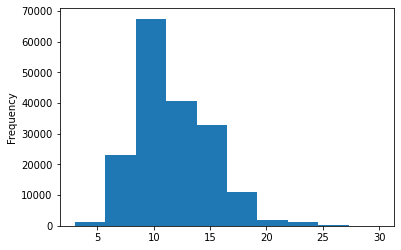

In [15]:
train_df.total_lines.plot.hist();

In [20]:
# convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_senteces = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making numeric labels (ML models require numeric labels)
1. One hot encode labels
2. Label Encoded Labels

In [16]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot.transform(test_df['target'].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [17]:
# Extract labels ('target' column) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_label_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_label_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_label_encoded = label_encoder.transform(test_df['target'].to_numpy())

len(train_label_encoded)

180040

In [18]:
# class name and number of class from LabelEncoder instances
num_classes = len(label_encoder.classes_)

num_classes, label_encoder.classes_

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 1: Conv1D with Token Embedding

###Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.


In [21]:
import numpy as np
# how long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

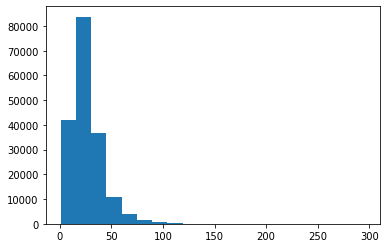

In [22]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [23]:
# how long of sentence lenght coves 95% of example?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [24]:
max(sent_lens)

296

### Create text vectorizer layer
We want to make a layer which maps our text from words to numbers

In [26]:
# How many words are in our vocab ? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [27]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                       output_sequence_length= output_seq_len) 

In [28]:
text_vectorizer.adapt(train_sentences)

In [29]:
# how many wrd in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Create custom text embbedding

In [30]:
import tensorflow as tf
from tensorflow.keras import layers

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), 
                               output_dim=128, 
                               mask_zero=True,)

###Creating datasets (making sure our data loads as fast as possible)


In [31]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_senteces, val_labels_one_hot ))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [32]:
# Take TensorSliceDataset's and turn them into prefetch dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset


<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [33]:
# create 1D conv model to processs seuences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
embedding = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs= layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [34]:
history_1 = model_1.fit(train_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1 * len(train_dataset)),
                        validation_data=valid_dataset,
                        validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 20s 11ms/step - loss: 0.9237 - accuracy: 0.6342 - val_loss: 0.6892 - val_accuracy: 0.7377
Epoch 2/5
562/562 [==============================] - 6s 11ms/step - loss: 0.6587 - accuracy: 0.7574 - val_loss: 0.6332 - val_accuracy: 0.7733
Epoch 3/5
562/562 [==============================] - 6s 10ms/step - loss: 0.6168 - accuracy: 0.7758 - val_loss: 0.5941 - val_accuracy: 0.7859
Epoch 4/5
562/562 [==============================] - 6s 10ms/step - loss: 0.5874 - accuracy: 0.7883 - val_loss: 0.5769 - val_accuracy: 0.7922
Epoch 5/5
562/562 [==============================] - 6s 10ms/step - loss: 0.5893 - accuracy: 0.7936 - val_loss: 0.5620 - val_accuracy: 0.7959


In [35]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5608 - accuracy: 0.8005


[0.5608193874359131, 0.8005097508430481]

In [39]:
# make predict on model
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 2, 2, 2, 2, 4, 1])>

In [40]:
model_1_results = calculate_results(val_label_encoded, model_1_preds)
model_1_results

{'accuracy': 80.05097312326228,
 'f1': 0.7973266210137907,
 'precision': 0.8006971020613579,
 'recall': 0.8005097312326228}

## Model 2: Feature extraction with pretrained token embeddings
Now lets use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder (USE): https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

In [42]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False)


In [43]:
# this model expect any input as list given in its docs
input = layers.Input(shape=[], dtype=tf.string)
x =  tf_hub_embedding_layer(input)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(input, output)

model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history_2 = model_2.fit(train_dataset,
                        epochs=5,
                        steps_per_epoch=len(train_dataset),
                        validation_data= valid_dataset,
                        validation_steps=len(valid_dataset))

Epoch 1/5
5627/5627 [==============================] - 124s 21ms/step - loss: 0.7316 - accuracy: 0.7202 - val_loss: 0.6567 - val_accuracy: 0.7500
Epoch 2/5
5627/5627 [==============================] - 126s 22ms/step - loss: 0.6359 - accuracy: 0.7588 - val_loss: 0.6220 - val_accuracy: 0.7631
Epoch 3/5
5627/5627 [==============================] - 99s 18ms/step - loss: 0.6012 - accuracy: 0.7732 - val_loss: 0.6066 - val_accuracy: 0.7690
Epoch 4/5
5627/5627 [==============================] - 101s 18ms/step - loss: 0.5787 - accuracy: 0.7815 - val_loss: 0.6004 - val_accuracy: 0.7724
Epoch 5/5
5627/5627 [==============================] - 124s 22ms/step - loss: 0.5619 - accuracy: 0.7886 - val_loss: 0.5978 - val_accuracy: 0.7721


In [44]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred = tf.argmax(model_2_pred_probs, axis=1)
model_2_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [45]:
model_2_results = calculate_results(val_label_encoded, model_2_pred)
model_2_results

{'accuracy': 77.21104197007811,
 'f1': 0.7683281413978935,
 'precision': 0.7706456817912322,
 'recall': 0.7721104197007811}

## Model 3: Conv1D with character embeddings

In [46]:
# Make functio to split setences into characters
def split_chars(text):
  return ' '.join(list(text))

# Text split non-character level seuence into character
split_chars('I love Tensorflow')

'I   l o v e   T e n s o r f l o w'

In [47]:
# Split sequence-level data split into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_senteces]
test_char = [split_chars(sentence) for sentence in test_sentences]
train_chars[:10]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [48]:
# What's the average character length?
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_lens)
mean_char_len

149.3662574983337

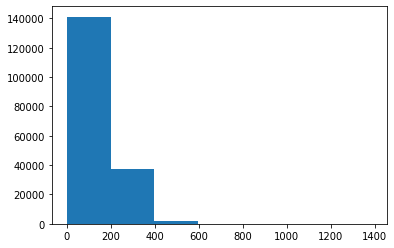

In [49]:
# check distribution of seuence at characte level
import matplotlib.pyplot as plt
plt.hist(chars_lens, bins=7);

In [50]:
# Find what characte length conver 9% of sequence
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [51]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase+string.digits+string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

### Create char-level token vectorizer istance


In [52]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (out of voacb, ['UNK'])
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len)

In [53]:
char_vectorizer.adapt(train_chars)

### Creating embedding layer


In [55]:
char_vector_vocal_len = len(char_vectorizer.get_vocabulary())
char_vector_vocal_len

28

In [56]:
char_embed = layers.Embedding(input_dim=char_vector_vocal_len,
                             output_dim=25,
                             mask_zero=True)

### Prepare Dataset and Creating Model with Conv1D

In [57]:
# create char level dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_char, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [58]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(64, kernel_size=5, padding='same',activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
output = layers.Dense(num_classes, activation='softmax')(x)
model_03 = tf.keras.Model(inputs,output)

model_03.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history_03 = model_03.fit(train_char_dataset,
                        epochs=5,
                        steps_per_epoch=len(train_char_dataset),
                        validation_data= val_char_dataset,
                        validation_steps=len(val_char_dataset)) 

Epoch 1/5
5627/5627 [==============================] - 43s 7ms/step - loss: 0.8889 - accuracy: 0.6526 - val_loss: 0.7820 - val_accuracy: 0.6974
Epoch 2/5
5627/5627 [==============================] - 55s 10ms/step - loss: 0.7431 - accuracy: 0.7171 - val_loss: 0.7320 - val_accuracy: 0.7224
Epoch 3/5
5627/5627 [==============================] - 52s 9ms/step - loss: 0.7091 - accuracy: 0.7318 - val_loss: 0.7117 - val_accuracy: 0.7311
Epoch 4/5
5627/5627 [==============================] - 46s 8ms/step - loss: 0.6910 - accuracy: 0.7397 - val_loss: 0.6972 - val_accuracy: 0.7386
Epoch 5/5
5627/5627 [==============================] - 35s 6ms/step - loss: 0.6785 - accuracy: 0.7444 - val_loss: 0.6926 - val_accuracy: 0.7403


In [59]:
model_3_preds_probs = model_03.predict(val_char_dataset)
model_3_pred = tf.argmax(model_3_preds_probs, axis=1)
model_3_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 4, 1])>

In [60]:
model_3_result = calculate_results(val_label_encoded, model_3_pred)
model_3_result

{'accuracy': 74.03349662385807,
 'f1': 0.73363749700701,
 'precision': 0.7357613337911577,
 'recall': 0.7403349662385807}

##Model 4: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

### Create postional embeddigs

In [61]:
# how many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

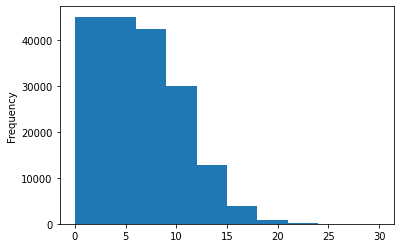

In [62]:
 # Check the distribution of 'line_number' column
 train_df.line_number.plot.hist();

In [63]:
# Use Tensorflow to create one-hot-encode tensors of our line_number column
train_line_number_one_hot = tf.one_hot(train_df.line_number, depth=15)
val_line_number_one_hot = tf.one_hot(val_df.line_number, depth=15)
test_line_number_one_hot = tf.one_hot(test_df.line_number, depth=15)
train_line_number_one_hot[:10], train_line_number_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

Now've encoded our line number features, lets do it for total line

In [64]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

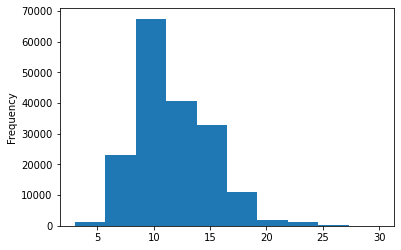

In [65]:
train_df.total_lines.plot.hist()

In [66]:
# Check the coverage of total line value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [67]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'], depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'], depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'], depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model

1. Buildign a `token-level` model
2. Create a `character-level` model
3. Create a model for `line_number` feature
4. Create a model for `total_lines` features
5. Combine output of 1 and 2 using tf.keras.layers.Concatenate
6. Combine output of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept tribied embedding and output label probabilities
8. Combine the inputs of 1,2,3,4 and output of into tf.keras.Model 

In [68]:
#1. Token inputs
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embedding = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embedding)
token_model = tf.keras.Model(token_inputs, token_output)

#2. Char Inputs
char_input = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vect = char_vectorizer(char_input)
char_embedding = char_embed(char_vect)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(char_input, char_bi_lstm)

#3. Create a line_number model 
line_number_input = layers.Input(shape=(15,), name = 'line_number_input')
line_number_output = layers.Dense(32, activation='relu')(line_number_input)
line_number_model = tf.keras.Model(line_number_input, line_number_output)

#4. Create a total lines model
total_line_input = layers.Input(shape=(20,), name='total_line_input')
total_lines_output = layers.Dense(32, activation='relu')(total_line_input)
total_line_model = tf.keras.Model(total_line_input, total_lines_output)

#5. Combine 1 and 2 using cocatination  
token_char_embedding = layers.Concatenate(name='char_token_embedding')([token_model.output, 
                                                                       char_model.output])
z = layers.Dense(256, activation='relu')(token_char_embedding)
z = layers.Dropout(0.5)(z)
#6. Combine positional embedding with combined token and car embedding
tribrid_embedding = layers.Concatenate(name='tribrid_embedding')([line_number_model.output,
                                                                 total_line_model.output,
                                                                 z] ) #layers does not gives any output but model does

#7. Create output layer
output = layers.Dense(5, activation='softmax', name='output_layer')(tribrid_embedding)

#form final model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                  total_line_model.input,
                                  token_model.input,
                                  char_model.input],
                          outputs=output)


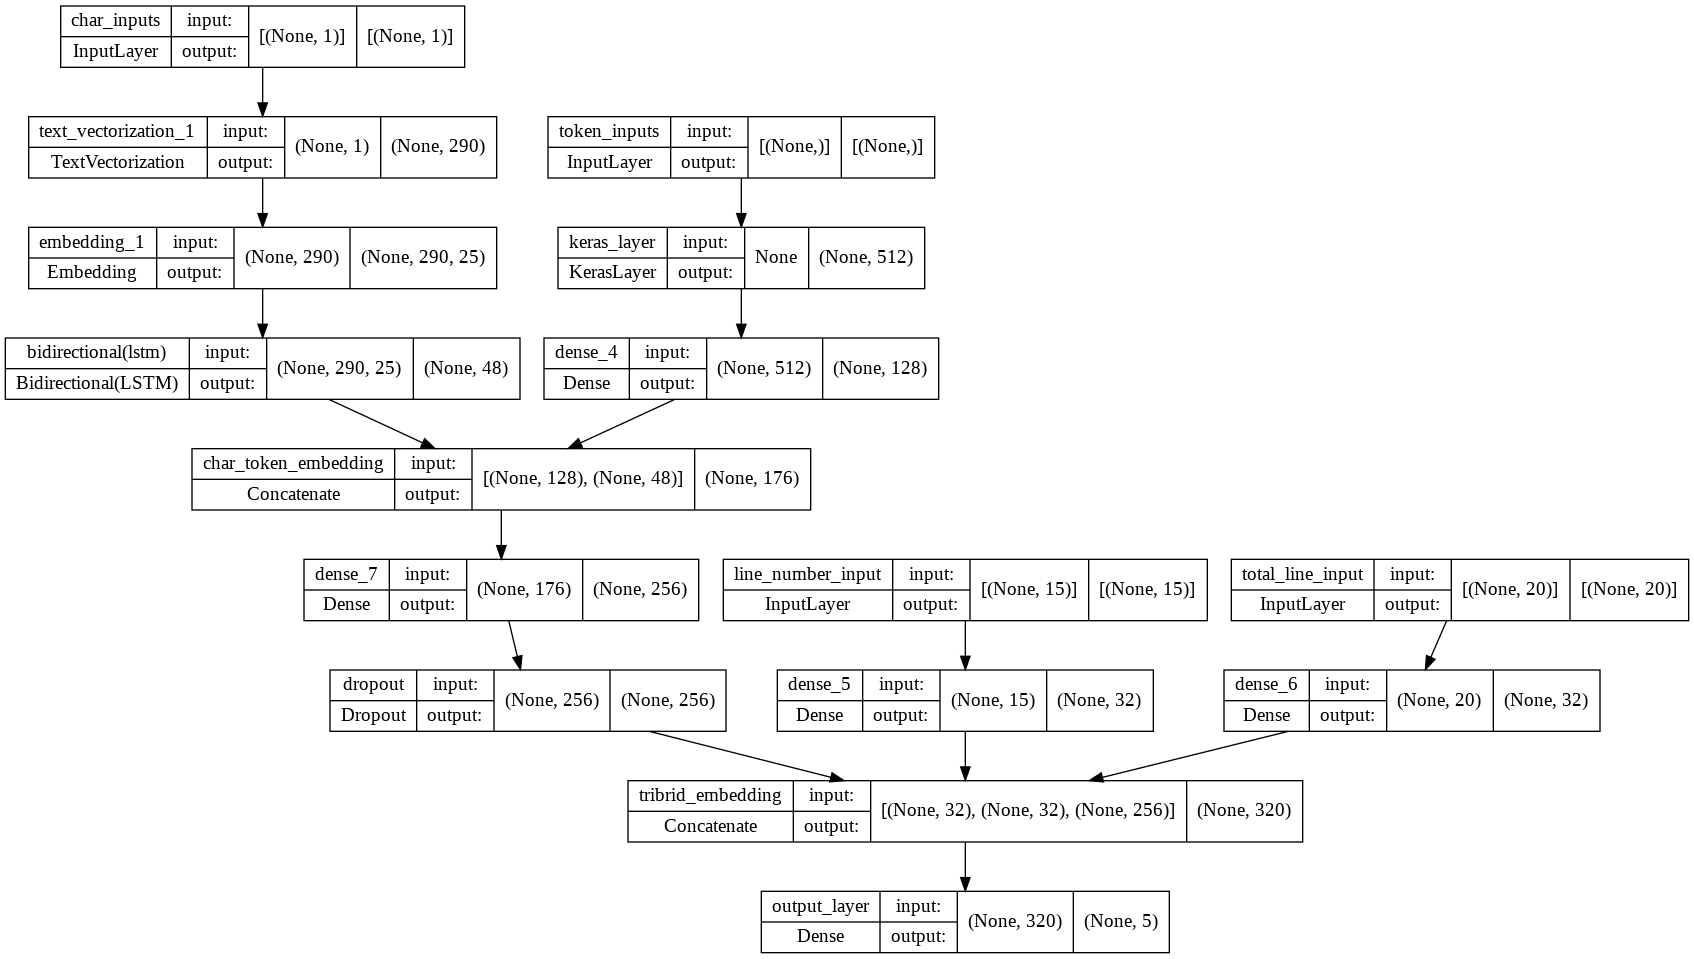

In [69]:
# plot hybrid token and character model
from keras.utils.vis_utils import plot_model
plot_model(model_5, show_shapes=True)

In [74]:
# Compile model 
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer='adam',
                metrics=['accuracy'])

###Create tribrid embedding datasets using tf.data

In [70]:
train_line_total_token_char_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot, 
                                                                      train_total_lines_one_hot,
                                                                      train_sentences, 
                                                                      train_chars))
train_label_data = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_line_total_token_char_dataset = tf.data.Dataset.zip((train_line_total_token_char_data, train_label_data))

train_dataset = train_line_total_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [71]:
val_line_total_token_char_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot, 
                                                                      val_total_lines_one_hot,
                                                                      val_senteces, 
                                                                      val_chars))
val_label_data = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_line_total_token_char_dataset = tf.data.Dataset.zip((val_line_total_token_char_data, val_label_data))

val_dataset = val_line_total_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [72]:
test_line_total_token_char_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot, 
                                                                      test_total_lines_one_hot,
                                                                      test_sentences, 
                                                                      test_char))
test_label_data = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_line_total_token_char_dataset = tf.data.Dataset.zip((test_line_total_token_char_data, test_label_data))

test_dataset = test_line_total_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Fitting model on Tribrid Model

In [75]:
history_5 = model_5.fit(train_dataset,
                        epochs=5,
                        steps_per_epoch=len(train_dataset),
                        validation_data=val_dataset,
                        validation_steps=len(val_dataset))

Epoch 1/5
5627/5627 [==============================] - 356s 61ms/step - loss: 0.9514 - accuracy: 0.8256 - val_loss: 0.9073 - val_accuracy: 0.8499
Epoch 2/5
5627/5627 [==============================] - 316s 56ms/step - loss: 0.9079 - accuracy: 0.8550 - val_loss: 0.8986 - val_accuracy: 0.8547
Epoch 3/5
5627/5627 [==============================] - 315s 56ms/step - loss: 0.8948 - accuracy: 0.8644 - val_loss: 0.8967 - val_accuracy: 0.8572
Epoch 4/5
5627/5627 [==============================] - 316s 56ms/step - loss: 0.8865 - accuracy: 0.8707 - val_loss: 0.8974 - val_accuracy: 0.8559
Epoch 5/5
5627/5627 [==============================] - 316s 56ms/step - loss: 0.8795 - accuracy: 0.8757 - val_loss: 0.8958 - val_accuracy: 0.8566


In [76]:
model_5_ped_probs = model_5.predict(val_dataset)
model_5_pred = tf.argmax(model_5_ped_probs, axis=1)
model_5_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [77]:
model_5_result = calculate_results(val_label_encoded, model_5_pred)
model_5_result

{'accuracy': 85.66132662518204,
 'f1': 0.8536631941093957,
 'precision': 0.8587728524393548,
 'recall': 0.8566132662518204}

##Compare model result

In [78]:
all_model_result = pd.DataFrame({'model_1_cov1D': model_1_results,
                                 'model_2_pretrained_token_embedding': model_2_results,
                                 'model_3_custom_char_embedding': model_3_result,
                                 'model_4_tribrid_model': model_5_result,})
all_model_result =all_model_result.transpose()
all_model_result.accuracy = all_model_result.accuracy/100

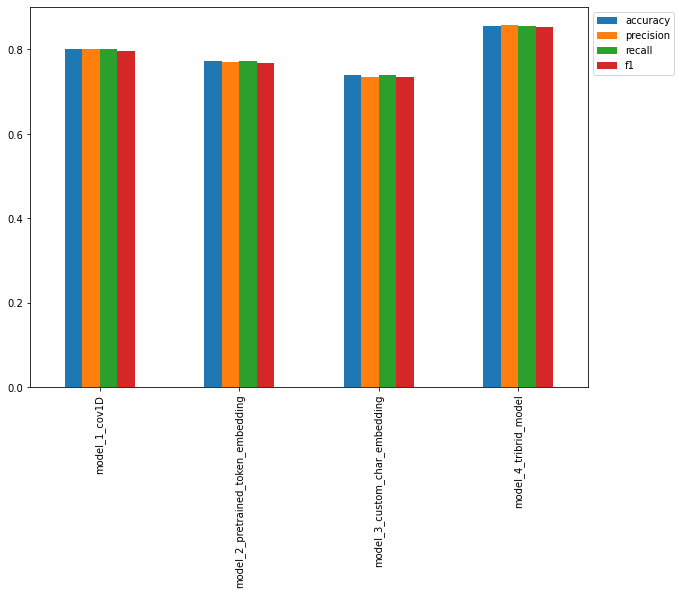

In [79]:
all_model_result.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

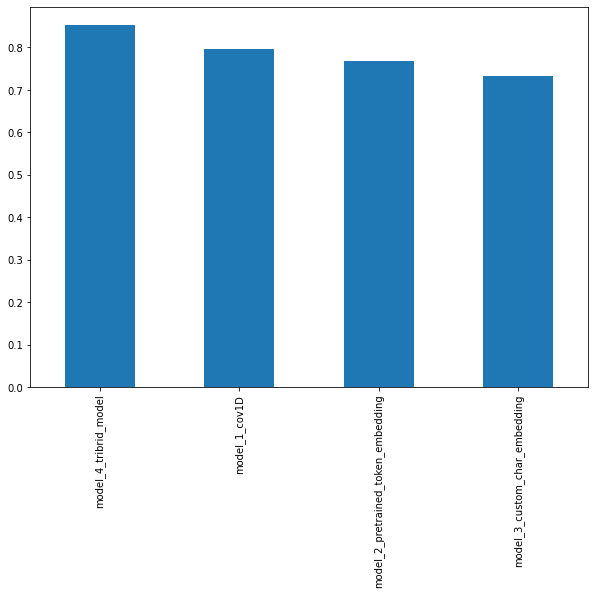

In [80]:
# Sort model results by f1-score
all_model_result.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Based on F1-scores, it looks like our tribrid embedding model performs the best by a fair margin.

##Save best performing model with 85.6% accuracy

In [ ]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") 